## LeafSnap Data Analysis using KNN

In [ ]:

import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, top_k_accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split


## Cleaning

In [ ]:

df = pd.read_csv('leafsnap-dataset-images.txt', sep='\t')

def is_mostly_black(file_path, threshold=15, black_ratio=0.95):
    try:
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=1)
        img = tf.image.resize(img, (224, 224))
        img_np = img.numpy()
        black_pixels = np.sum(img_np < threshold)
        total_pixels = img_np.size
        ratio = black_pixels / total_pixels
        return ratio >= black_ratio
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return False

species_black_counts = {}

print("Checking images for mostly black...")
for species in tqdm(df['species'].unique()):
    species_df = df[df['species'] == species]
    black_count = 0

    for path in species_df['segmented_path']:
        if is_mostly_black(path):
            black_count += 1

    total = len(species_df)
    black_ratio = black_count / total

    if black_ratio > 0.5:
        species_black_counts[species] = black_ratio

print("\nSpecies to remove (majority black images):")
for species, ratio in species_black_counts.items():
    print(f"{species}: {ratio:.2f}")

species_to_remove = list(species_black_counts.keys())
df_cleaned = df[~df['species'].isin(species_to_remove)].reset_index(drop=True)

print(f"\nOriginal species: {df['species'].nunique()}")
print(f"Remaining species after cleaning: {df_cleaned['species'].nunique()}")
print(f"Remaining images: {len(df_cleaned)}")

Checking images for mostly black...


100%|██████████| 185/185 [00:41<00:00,  4.45it/s]


Species to remove (majority black images):
Abies concolor: 0.99
Abies nordmanniana: 0.96
Acer ginnala: 0.53
Acer palmatum: 0.57
Acer rubrum: 0.70
Acer saccharinum: 0.63
Ailanthus altissima: 0.86
Amelanchier canadensis: 0.77
Asimina triloba: 0.56
Betula jacqemontii: 0.64
Betula lenta: 0.77
Betula nigra: 0.85
Betula populifolia: 0.82
Carpinus betulus: 0.77
Cedrus atlantica: 0.94
Cedrus deodara: 1.00
Cedrus libani: 1.00
Celtis occidentalis: 0.71
Cercidiphyllum japonicum: 0.55
Chamaecyparis pisifera: 0.83
Chionanthus retusus: 0.80
Cornus kousa: 0.56
Cornus mas: 0.70
Crataegus crus-galli: 0.89
Crataegus laevigata: 0.85
Crataegus phaenopyrum: 0.85
Cryptomeria japonica: 0.69
Diospyros virginiana: 0.71
Fraxinus americana: 0.80
Ginkgo biloba: 0.56
Gleditsia triacanthos: 0.71
Ilex opaca: 0.89
Juniperus virginiana: 0.72
Larix decidua: 0.99
Maclura pomifera: 0.86
Magnolia stellata: 0.55
Magnolia virginiana: 0.62
Malus baccata: 0.79
Malus floribunda: 0.77
Malus hupehensis: 0.61
Metasequoia glyptos

## Simple KNN

In [64]:
df = df_cleaned.copy()
species_counts = df['species'].value_counts()
species_to_keep = species_counts[species_counts >= 150].index
# remove magnolia macrophylla 

species_to_keep = species_to_keep[species_to_keep != 'Magnolia macrophylla']
print(species_to_keep.sort_values(ascending=False))
df = df[df['species'].isin(species_to_keep)].reset_index(drop=True)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['species'])

IMG_SIZE = (244, 244)

def extract_features(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    img = tf.image.rgb_to_grayscale(img)
    feature_vector = tf.reshape(img, [-1]) 
    return feature_vector.numpy()

features = []
labels = []

for path, label in zip(df['segmented_path'], encoded_labels):
    try:
        feature = extract_features(path)
        features.append(feature)
        labels.append(label)
    except Exception as e:
        print(f"Error processing {path}: {e}")

features = np.array(features)
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, stratify=labels, random_state=42
)


print(f"Species to keep: {species_to_keep.size}")
print(f"Feature shape: {features.shape}")


Index(['Ulmus pumila', 'Ulmus glabra', 'Quercus velutina', 'Quercus stellata',
       'Quercus shumardii', 'Quercus muehlenbergii', 'Quercus michauxii',
       'Quercus marilandica', 'Quercus macrocarpa', 'Pyrus calleryana',
       'Prunus sargentii', 'Populus grandidentata', 'Populus deltoides',
       'Platanus occidentalis', 'Oxydendrum arboreum', 'Magnolia tripetala',
       'Magnolia denudata', 'Liriodendron tulipifera',
       'Liquidambar styraciflua', 'Koelreuteria paniculata', 'Juglans nigra',
       'Juglans cinerea', 'Fraxinus nigra', 'Ficus carica',
       'Fagus grandifolia', 'Eucommia ulmoides', 'Cornus florida',
       'Cladrastis lutea', 'Cercis canadensis', 'Catalpa speciosa',
       'Catalpa bignonioides', 'Castanea dentata', 'Carya tomentosa',
       'Carya ovata', 'Carya glabra', 'Carya cordiformis',
       'Broussonettia papyrifera', 'Betula alleghaniensis', 'Aesculus pavi',
       'Aesculus glabra', 'Acer saccharum'],
      dtype='object', name='species')
Species 

### Train

In [70]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_train, y_train)

# knn = KNeighborsClassifier()
# param_grid = {'n_neighbors': np.arange(1, 20)}
# grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# best_k = grid_search.best_params_['n_neighbors']
# print(f"Best k value: {best_k}")

KNeighborsClassifier(weights='distance')

### Evaluate & Visualize

KNN Test Accuracy (Top-1): 0.3578
KNN Test Accuracy (Top-5): 0.6057


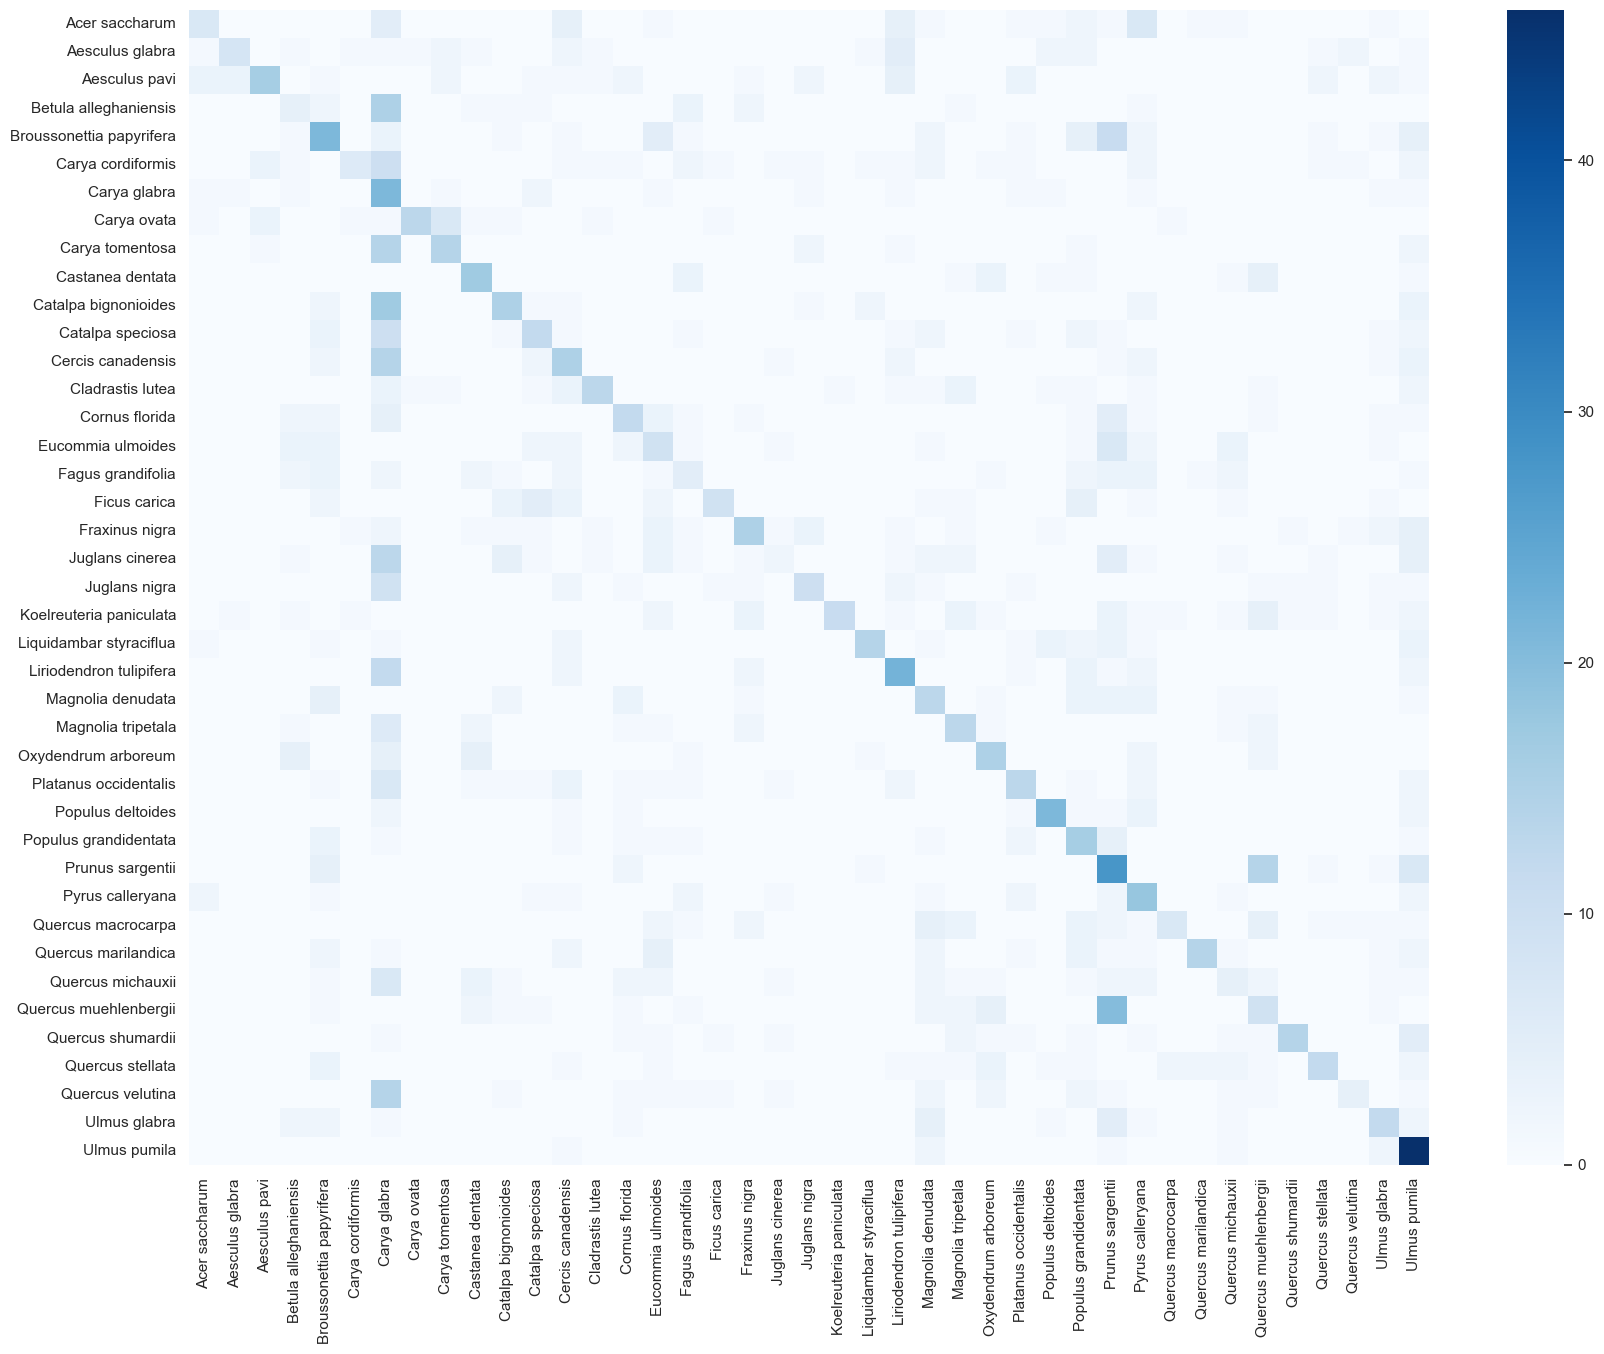

In [66]:
y_pred = knn.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 15))
cm_df = pd.DataFrame(cm, index=label_encoder.inverse_transform(range(len(species_to_keep))),
                     columns=label_encoder.inverse_transform(range(len(species_to_keep))))
sns.heatmap(cm_df, annot=False, fmt='d', cmap='Blues')

acc = accuracy_score(y_test, y_pred)
top5_acc = top_k_accuracy_score(y_test, knn.predict_proba(X_test), k=5)
print(f"KNN Test Accuracy (Top-1): {acc:.4f}")
print(f"KNN Test Accuracy (Top-5): {top5_acc:.4f}")


## Fancy KNN
- Leaf Contour 
- Hu Moments
- PCA Dimentionality Reduction 

In [ ]:
IMG_SIZE = (224, 224)

def extract_features(file_path, bins=30):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.image.rgb_to_grayscale(img)
    img_np = img.numpy()
    img_np = (img_np * 255).astype(np.uint8)

    contours, _ = cv2.findContours(img_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return np.zeros(bins + 7)

    largest_contour = max(contours, key=cv2.contourArea)
    largest_contour = largest_contour.squeeze()

    if largest_contour.ndim != 2 or largest_contour.shape[0] < 5:
        return np.zeros(bins + 7)

    dx = np.gradient(largest_contour[:, 0])
    dy = np.gradient(largest_contour[:, 1])
    angles = np.arctan2(dy, dx)
    curvature = np.gradient(angles)
    hist, _ = np.histogram(curvature, bins=bins, range=(-np.pi, np.pi), density=True)

    hu = cv2.HuMoments(cv2.moments(largest_contour)).flatten()

    full_feature = np.concatenate([hist, hu])
    return full_feature

features = []
labels = []

for path, label in zip(df['segmented_path'], encoded_labels):
    try:
        feature = extract_features(path)
        features.append(feature)
        labels.append(label)
    except Exception as e:
        print(f"Error processing {path}: {e}")

features = np.array(features)
labels = np.array(labels)

print(f"Feature shape before PCA: {features.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, stratify=labels, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

n_components = min(X_train_scaled.shape[0], X_train_scaled.shape[1], 50)
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Feature shape after PCA: {X_train_pca.shape}")

knn = KNeighborsClassifier(n_neighbors=5, metric='cosine', weights='distance')
knn.fit(X_train_pca, y_train)

y_pred = knn.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)
top5_acc = top_k_accuracy_score(y_test, knn.predict_proba(X_test_pca), k=5)

print(f"KNN Test Accuracy (Top-1): {acc:.4f}")
print(f"KNN Test Accuracy (Top-5): {top5_acc:.4f}")


Feature shape before PCA: (2733, 37)
Feature shape after PCA: (2186, 37)
KNN Test Accuracy (Top-1): 0.4662
KNN Test Accuracy (Top-5): 0.8428
